In [1]:
import sys
import os

# Get the current directory
current_path = os.getcwd()

# Add the current directory to sys.path
sys.path.append(current_path)

# Now you can import modules from the current directory

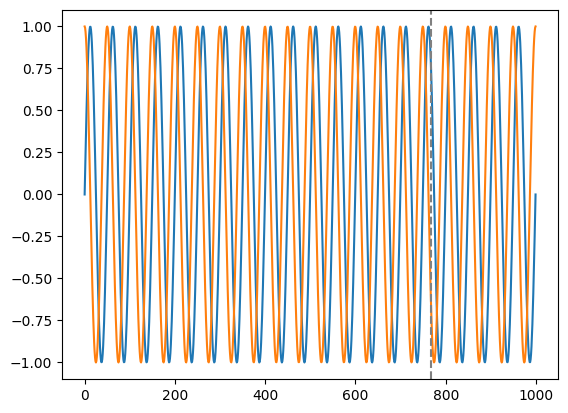

In [2]:
from Timer import Model
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import math
import matplotlib.pyplot as plt

# Define the data generation function
def generate_data(num_points):
    x = np.linspace(0, 2 * math.pi*20, num_points)
    sine_data = np.sin(x)
    cosine_data = np.cos(x)
    return np.array(list(zip(sine_data, cosine_data)))

# Define a simple Time Series Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len
    
    def __len__(self):
        return len(self.data) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_len]
        y = self.data[idx+self.input_len:idx+self.input_len+self.output_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters for dataset
input_len = 20
output_len = 20
num_points = 1000

# Generate data
data = generate_data(num_points)

# Create dataset
dataset = TimeSeriesDataset(data, input_len, output_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = Subset(dataset, range(train_size)), Subset(dataset, range(train_size, len(dataset)))


plt.plot(data)
plt.axvline(x=train_size, color='gray', linestyle='--')  # Vertical line separating input and output



# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:
from TrmEncoder import Model
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import math

# Assuming 'Model' is already defined and imported
class Args() :
    def __init__(self):
        self.task_name= 'forecast'
        self.ckpt_path= ''
        #self.seq_len= 20
        self.pred_len= 20
        self.patch_len= 10
        self.d_model= 64
        self.d_ff= 256
        self.e_layers= 3
        self.n_heads= 4
        self.dropout= 0.1
        self.output_attention= False
        self.factor= False
        self.activation= False

args = Args()
# Instantiate model
model_enc = Model(args)
optimizer = torch.optim.Adam(model_enc.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop
model_enc.train()
for epoch in range(10):  # Number of epochs
    total_loss = 0
    prev_inputs = None
    count=0
    for inputs, targets in train_loader:
        count += 1
        if prev_inputs is not None:
            inputs = torch.cat((prev_inputs, inputs), dim=1)
        optimizer.zero_grad()
        outputs = model_enc(inputs,(input_len*count),None,None,None)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        prev_inputs = inputs.detach()
        
    print(f'Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader)}')

# Evaluate the model
model_enc.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model_enc(inputs,input_len,None,None,None)
        loss = criterion(outputs, targets)
        print(f'Test Loss: {loss.item()}')


Epoch 1, Average Loss: 0.7998250052332878
Epoch 2, Average Loss: 0.7650379737218221
Epoch 3, Average Loss: 0.7482423459490141
Epoch 4, Average Loss: 0.7733021055658659
Epoch 5, Average Loss: 0.7547077313065529
Epoch 6, Average Loss: 0.7382688994208971
Epoch 7, Average Loss: 0.7364074115951856
Epoch 8, Average Loss: 0.7458207706610361
Epoch 9, Average Loss: 0.7302636578679085
Epoch 10, Average Loss: 0.7151800965269407
Test Loss: 1.2637916803359985
Test Loss: 1.3040708303451538
Test Loss: 1.249762773513794
Test Loss: 1.3186581134796143
Test Loss: 1.3459298610687256
Test Loss: 1.3306071758270264
Test Loss: 1.2847959995269775


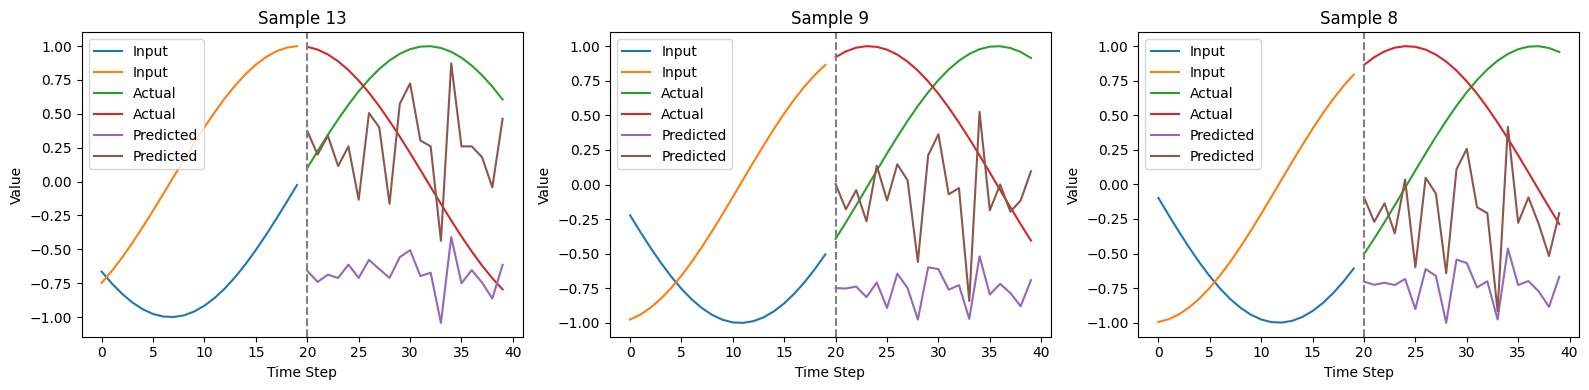

In [8]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(test_loader))
output = model_enc(input_seq, input_len, None,None,None)

# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()